In [237]:
# Если необходимо то установите эту библиотеку
pip install PrettyTable

  Stored in directory: C:\Users\Volk\AppData\Local\pip\Cache\wheels\80\34\1c\3967380d9676d162cb59513bd9dc862d0584e045a162095606
Successfully built PrettyTable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from scipy.stats import norm
from prettytable import PrettyTable

In [2]:
data = pd.read_csv('data.csv')
# Сразу удалим id продукта b id магазина они нам не понадабятся
data.drop('Item_Identifier', axis=1, inplace=True)
data.drop('Outlet_Identifier', axis=1, inplace=True)
data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:

# Превращаем строковые переменные в логические массивы
X_ItemFatContent=pd.get_dummies(data[['Item_Fat_Content']])
X_ItemType=pd.get_dummies(data[['Item_Type']])
X_OutletSize=pd.get_dummies(data[['Outlet_Size']])
X_OutletLocationType=pd.get_dummies(data[['Outlet_Location_Type']])
X_OutletType=pd.get_dummies(data[['Outlet_Type']])

# Замена nan на средние значения (для числовых переменных) (для категориальныйх nan были отсеены на предыдущем этапе)
data0=data[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year','Item_Outlet_Sales']]
columns = data0.columns
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
imputer.fit(data0)
data0_imputed = imputer.transform(data0)
data0 = pd.DataFrame(data0_imputed, columns=columns)

C:\Users\Volk\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000278092FD668>,
      dtype=object)

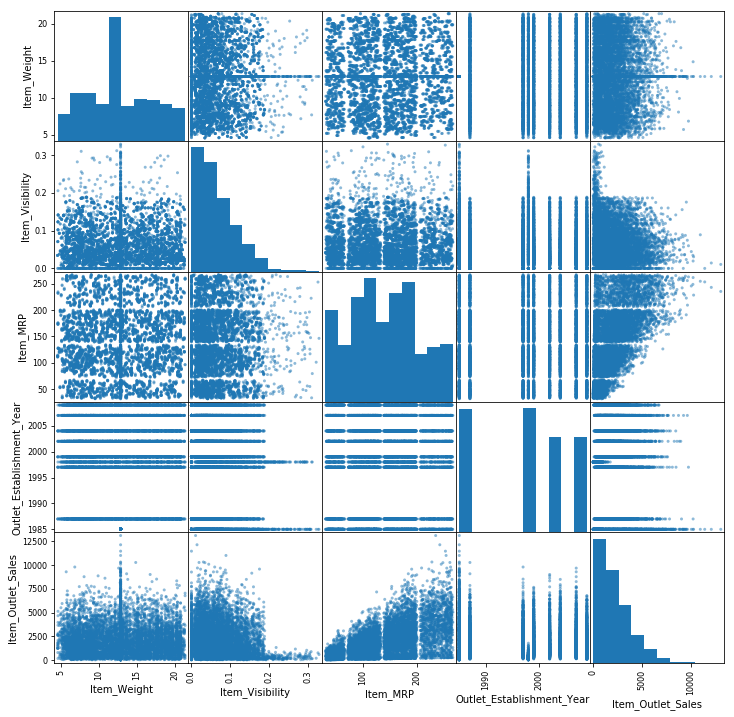

In [7]:
#Визуализируем численные данные в виде матрицы кроссплотов с гистограммами распределений по диагонали.
pd.plotting.scatter_matrix(data0, figsize=(12,12))

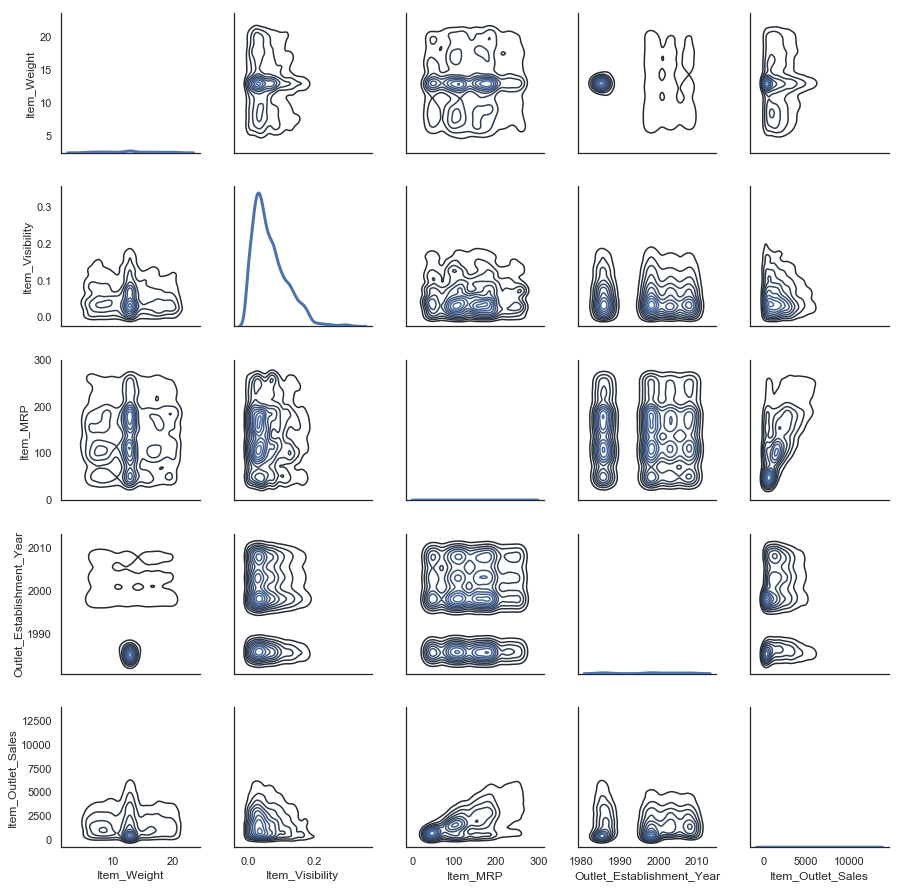

In [8]:
#Рассмотрим теже графики, но добавим плотность точек
sns.set(style="white")
g = sns.PairGrid(data0)
g.map_lower(sns.kdeplot)
g.map_upper(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3)

In [9]:
corr=pd.concat([data0,X_ItemFatContent,X_ItemType,X_OutletSize,X_OutletLocationType,X_OutletType], axis=1, sort=False).corr()
corr.style.background_gradient(cmap='coolwarm')

Как можно видеть самые высокие коеффициенты модуля корреляции у целевого параметра ("Item_Outlet_Sales") с параметрами:
Item_MRP (0.57), Outlet_Type_Supermarket Type3 (0.31), Outlet_Type_Grocery Store (0.41)

In [10]:
# Разделение на обучающую и контрольную выборки
sss = ShuffleSplit(n_splits=1, test_size=0.2)
sss.get_n_splits(data0)
trn_idx, tst_idx = next(sss.split(data0))

In [11]:
# Нормировка данных.
scaler = StandardScaler()
scaler.fit(pd.DataFrame(data0.values[list(trn_idx)], columns=data0.columns))
data1=pd.DataFrame(scaler.transform(data0), columns=data0.columns)

In [12]:
# Создаем итогового массив X
X=pd.concat([data1[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']],
            X_ItemFatContent,X_ItemType,X_OutletSize,X_OutletLocationType,X_OutletType], axis=1, sort=False)
# Создаем итогового массив y
y=data1[['Item_Outlet_Sales']]

In [13]:
# Создание итоговых нормированный массивов X_trn, X_tst, y_trn, y_tst
X_trn=pd.DataFrame(X.values[list(trn_idx)], columns=X.columns)
X_tst=pd.DataFrame(X.values[list(tst_idx)], columns=X.columns)
y_trn=pd.DataFrame(y.values[list(trn_idx)], columns=y.columns)
y_tst=pd.DataFrame(y.values[list(tst_idx)], columns=y.columns)

In [14]:
def metric_func(y_true,y_pred,variant):
    rezult=float('NaN')
    inf0=''
    if variant==0:
        rezult=metrics.explained_variance_score(y_true, y_pred)
        inf0='Explained variance regression score function'
#   elif variant==1: Не поддерживается моей версией sklearn.
#       rezult=metrics.max_error(y_true, y_pred)
#       inf0='Metric calculates the maximum residual error'
    elif variant==1:
        rezult=metrics.mean_absolute_error(y_true, y_pred)
        inf0='Mean absolute error regression loss'
    elif variant==2:
        rezult=metrics.mean_squared_error(y_true, y_pred)
        inf0='Mean squared error regression loss'
#    elif variant==3: Не расчитывается, т.к. y_pred иногда принимает отрицательные значения.
#        rezult=metrics.mean_squared_log_error(y_true, y_pred)
#        inf0='Mean squared logarithmic error regression loss'
    elif variant==3:
        rezult=metrics.median_absolute_error(y_true, y_pred)
        inf0='Median absolute error regression loss'
    elif variant==4:
        rezult=metrics.r2_score(y_true, y_pred)
        inf0='R^2 (coefficient of determination)'
    return rezult, inf0

In [15]:
# Для выбора метрики оценки качества построения модели на модели случайных деревьев
# рассмотрим несколько метрик внутри kfold разбиения.

n_kfold=200

kf = KFold(n_splits=n_kfold, random_state=123, shuffle=True)
model = RandomForestRegressor(n_estimators=20, n_jobs=10)

first_iter_flag = 0
flag0=0
for kf_trn_idx, kf_tst_idx in kf.split(X_trn):
    X_trn2, X_tst2 = X_trn.values[kf_trn_idx], X_trn.values[kf_tst_idx]
    y_trn2, y_tst2 = y_trn.values[kf_trn_idx], y_trn.values[kf_tst_idx]
    model.fit(X_trn2, y_trn2.ravel())
    imp = model.feature_importances_
    y_prd2=model.predict(X_tst2)
    r2_val=[]
    for i in range(0,5):
        rez,inf0=metric_func(y_tst2,y_prd2,i)
        r2_val.append(rez.round(3))
    if flag0==0:
        flag0=1
        imp0=imp
        r_val=r2_val
    else:
        r_val=np.vstack([r_val,r2_val])
        imp0=imp0+imp   
imp0=imp0/n_kfold
ix=np.argsort(-imp0)

Самый важный признак (первые пять).

In [16]:
for i in range(1,6):
    print(X.columns[ix[i]],': ',str(imp0[ix[i]].round(3)))

Outlet_Type_Grocery Store :  0.19
Item_Visibility :  0.1
Outlet_Establishment_Year :  0.068
Item_Weight :  0.053
Outlet_Type_Supermarket Type3 :  0.023


C:\Users\Volk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\Volk\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Volk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\Volk\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Volk\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplot

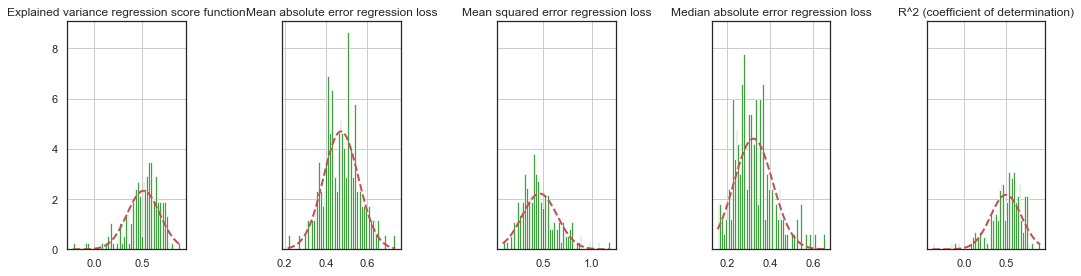

In [21]:
fig, axs = plt.subplots(1, 5, sharey=True, tight_layout=True, figsize=(15, 4))

# best fit of data

for i in range(0,5):
    rez,inf0 = metric_func([0,1,2,3,4,5],[0,1,2,3,4,5],i)
    n, bins, patches = axs[i].hist(r_val[:,i],60 , normed=1, facecolor='green', alpha=0.75)
    axs[i].title.set_text(inf0)
    
    (mu, sigma) = norm.fit(r_val[:,i])
    y_buf = mlab.normpdf( bins, mu, sigma)
    axs[i].plot(bins, y_buf, 'r--', linewidth=2)
    axs[i].grid(True)

Как можно видеть распределение метрики "Модуля средней ошибки" ближе всего к гаусовскому\нормальному распределению, таким образом она лучше всего подойдет для оценки качества нашей итоговой модели (т.к. для стат.обработки номальное распределение удобнее (мат.ожидание совпадает со средним арифметическим)).
Однако эта оценка может быть не достаточной, поэтому в качестве дополнительной метрики используем квадрат корреляции.

In [22]:
n_pca=list(range(2,int(X.shape[1]/2)+1))
n_kfold=10

kf = KFold(n_splits=n_kfold, random_state=123, shuffle=True)
model = RandomForestRegressor(n_estimators=20, n_jobs=10)

first_iter_flag = 0
flag0=0
metric1_val2=[];
metric2_val2=[];
for n in n_pca:
    pca = PCA(n_components=n)
    pca.fit(X_trn)
    X_pca_trn=pca.transform(X_trn)
    metric1_val=0
    metric2_val=0
    for kf_trn_idx, kf_tst_idx in kf.split(X_trn):
        X_trn2, X_tst2 = X_pca_trn[kf_trn_idx], X_pca_trn[kf_tst_idx]
        y_trn2, y_tst2 = y_trn.values[kf_trn_idx], y_trn.values[kf_tst_idx]
        model.fit(X_trn2, y_trn2.ravel())
        y_prd2=model.predict(X_tst2)
        metric1_val=metric1_val+metric_func(y_tst2,y_prd2,1)[0]
        metric2_val=metric2_val+metric_func(y_tst2,y_prd2,4)[0]
    metric1_val2.append(metric1_val/n_kfold)
    metric2_val2.append(metric2_val/n_kfold)

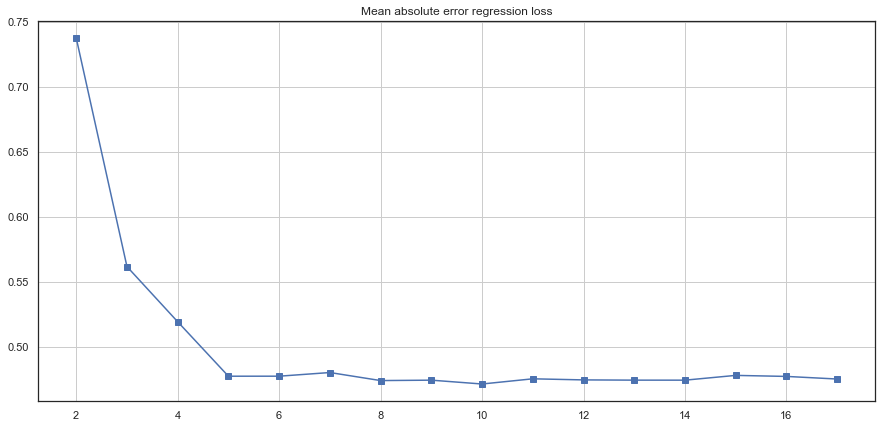

In [23]:
plt.figure(figsize=(15, 7))
plt.plot(n_pca, metric1_val2, 'bs-')
plt.grid(True)
plt.title(metric_func([0,1,2,3,4,5],[0,1,2,3,4,5],1)[1])
plt.show()

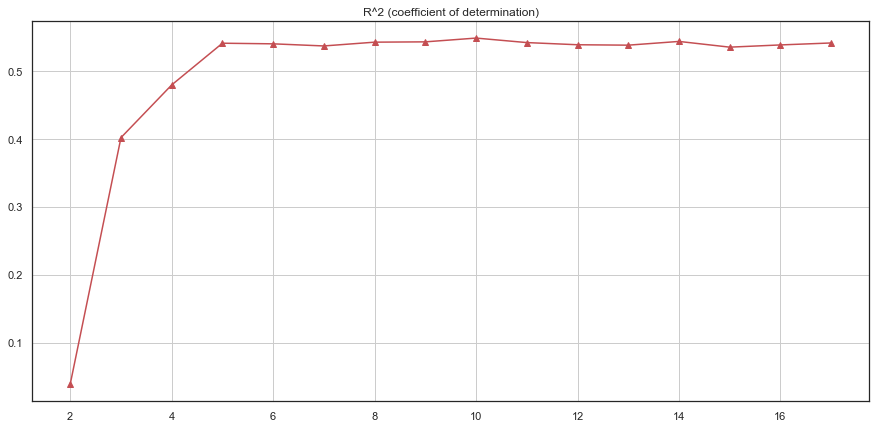

In [24]:
plt.figure(figsize=(15, 7))
plt.plot(n_pca, metric2_val2, 'r^-')
plt.grid(True)
plt.title(metric_func([0,1,2,3,4,5],[0,1,2,3,4,5],4)[1])
plt.show()

Как видно из графиков обе метрики выпалаживаются после значения n_pca=8. Для ускорения расчетов и из соображений рациональности в дальнейшем вместо исходного X используем X.pca(n=8).

In [25]:
str0=[]
for i in range(1,9):
    str0.append('PCA feacher ' + str(i))

pca = PCA(n_components=8)
pca.fit(X_trn)
X_pca_trn=pd.DataFrame(pca.transform(X_trn), columns=str0)
X_pca_tst=pd.DataFrame(pca.transform(X_tst), columns=str0)
X_pca=pd.DataFrame(pca.transform(X), columns=str0)

In [26]:
# Рассмортим несколько методов регрессии
algorithms = [
    RandomForestRegressor(n_estimators=20, max_depth = 5, min_samples_leaf = 20, max_features = 0.5, n_jobs = 10),
    HuberRegressor(),
    KNeighborsRegressor(n_neighbors=5),
    SVR(gamma='scale', C=1.0, epsilon=0.2),
]
algorithms_inf0=['Ranfor','Huber','KNN','SVR']
algorithms_inf0_4table=['','Ranfor','Huber','KNN','SVR']

In [27]:
# Оценим качество этих моделей внутри кфолд разбиения
n_kfold=10
kf = KFold(n_splits=n_kfold, random_state=54321, shuffle=True)
metric1_val2=np.zeros(4)
metric2_val2=np.zeros(4)
for kf_trn_idx, kf_tst_idx in kf.split(X_trn):
    X_trn2, X_tst2 = X_pca_trn.values[kf_trn_idx], X_pca_trn.values[kf_tst_idx]
    y_trn2, y_tst2 = y_trn.values[kf_trn_idx], y_trn.values[kf_tst_idx]
    metric1_val=[]
    metric2_val=[]
    for i in range(0,4):
        model=algorithms[i]
        model.fit(X_trn2, y_trn2.ravel())
        y_prd2=model.predict(X_tst2)
        metric1_val.append(metric_func(y_tst2,y_prd2,1)[0])
        metric2_val.append(metric_func(y_tst2,y_prd2,4)[0])
    metric1_val2=metric1_val2+np.array(metric1_val)
    metric2_val2=metric2_val2+np.array(metric2_val)
metric1_val2 = metric1_val2/n_kfold
metric2_val2 = metric2_val2/n_kfold

In [28]:

t = PrettyTable(algorithms_inf0_4table)
p=list(metric1_val2.round(3))
p.insert(0,'Модуля ошибки')
t.add_row(p)
p=list(metric2_val2.round(3))
p.insert(0,'Корреляций')
t.add_row(p)
print('Результат по k-fold')
print(t)

Результат по k-fold
+---------------+--------+-------+-------+-------+
|               | Ranfor | Huber |  KNN  |  SVR  |
+---------------+--------+-------+-------+-------+
| Модуля ошибки | 0.485  | 0.547 | 0.484 |  0.45 |
|   Корреляций  | 0.548  | 0.441 | 0.517 | 0.588 |
+---------------+--------+-------+-------+-------+


In [29]:
metric1_val=[]
metric2_val=[]
for i in range(0,4):
    model=algorithms[i]
    model.fit(X_pca_trn, y_trn)
    y_prd=model.predict(X_pca_tst)
    metric1_val.append(metric_func(y_tst,y_prd,1)[0])
    metric2_val.append(metric_func(y_tst,y_prd,4)[0])

C:\Users\Volk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\Volk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Volk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
t = PrettyTable(algorithms_inf0_4table)
p=list(np.round(metric1_val,3))
p.insert(0,'Модуля ошибки')
t.add_row(p)
p=list(np.round(metric2_val,3))
p.insert(0,'Корреляций')
t.add_row(p)
print('Результат на отложенной выборке')
print(t)

Результат на отложенной выборке
+---------------+--------+-------+-------+-------+
|               | Ranfor | Huber |  KNN  |  SVR  |
+---------------+--------+-------+-------+-------+
| Модуля ошибки | 0.491  | 0.559 | 0.482 | 0.447 |
|   Корреляций  |  0.55  | 0.426 | 0.539 | 0.606 |
+---------------+--------+-------+-------+-------+


Как можно видеть SVR дает лучшее значение и по средней оценке kfold и на базовой отложенной выборке.

Теперь приступим к стекингу.

In [31]:
# В качестве метоалгоритма рассмортим случайный лес, kNN и SVR
algorithms_meta = [
    RandomForestRegressor(n_estimators=20, max_depth = 5, min_samples_leaf = 20, max_features = 0.5, n_jobs = 10),
    KNeighborsRegressor(n_neighbors=5),
    SVR(gamma='scale', C=1.0, epsilon=0.2),
]
algorithms_meta_inf0=['Ranfor','KNN','SVR']
algorithms_meta_inf0_4table=['','Ranfor','KNN','SVR']

In [32]:
# Подготовка данных для стекинга
from sklearn.model_selection import StratifiedKFold
stack_cv = StratifiedKFold(n_splits=10, random_state=12345)
meta_train = np.zeros([X.shape[0],len(algorithms)])
meta_train.fill(np.nan)
col_names = []
k=0;
for i in range(0,len(algorithms)):
    model=algorithms[i]
    for j, (trn_cv_idx, tst_cv_idx) in enumerate(stack_cv.split(X_pca, y.values.argmax(1))):
        model.fit(X_pca.iloc[trn_cv_idx], y.iloc[trn_cv_idx].values.ravel())
        meta_train[tst_cv_idx,i]=model.predict(X_pca.iloc[tst_cv_idx])
meta_train=np.concatenate([meta_train**2, meta_train], axis=1) # Добавим квадраты вычесленных результатов младших моделей

In [33]:
metric1_val=[]
metric2_val=[]
y_meta_pred = np.zeros([y_tst.shape[0],len(algorithms_meta)])
y_meta_pred.fill(np.nan)
for i in range(0,len(algorithms_meta)):
    model=algorithms_meta[i]
    model.fit(meta_train[trn_idx,:], y.values[trn_idx].ravel())
    y_meta_pred[:,i]=model.predict(meta_train[tst_idx,:])
    metric1_val.append(metric_func(y_tst,y_meta_pred[:,i],1)[0])
    metric2_val.append(metric_func(y_tst,y_meta_pred[:,i],4)[0])

In [34]:
t = PrettyTable(algorithms_meta_inf0_4table)
p=list(np.round(metric1_val,3))
p.insert(0,'Модуля ошибки')
t.add_row(p)
p=list(np.round(metric2_val,3))
p.insert(0,'Корреляций')
t.add_row(p)
print('Результат стекинга на отложенной выборке')
print(t)

Результат стекинга на отложенной выборке
+---------------+--------+-------+-------+
|               | Ranfor |  KNN  |  SVR  |
+---------------+--------+-------+-------+
| Модуля ошибки | 0.451  | 0.479 | 0.454 |
|   Корреляций  | 0.601  |  0.54 | 0.591 |
+---------------+--------+-------+-------+


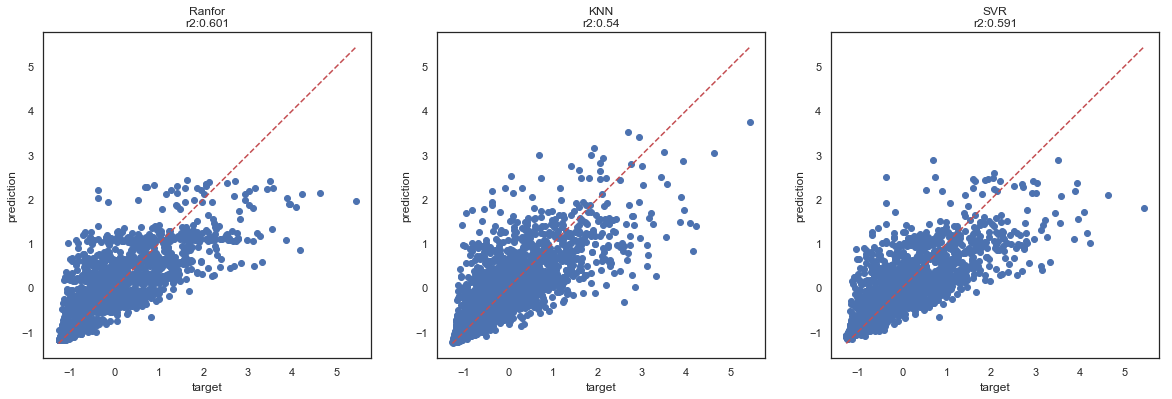

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
k=0;
for ax in axes:

    mi=min([y_tst.values.min(),y_meta_pred[:,k].min()])
    ma=max([y_tst.values.max(),y_meta_pred[:,k].max()])
    ax.scatter(y_tst, y_meta_pred[:,k])
    ax.plot([mi,ma], [mi,ma] ,'r--')
    ax.set_title(algorithms_meta_inf0[k]+'\nr2:'+ str(metric2_val[k].round(3)))
    ax.set(xlabel='target', ylabel='prediction')
    k=k+1